# Switch CREG12.L75 to both Xarray & Dask for the analyse

In [161]:
import dask_hpcconfig
from distributed import Client
dask_hpcconfig.print_clusters()
clusters = dask_hpcconfig.available_clusters()
clusters

Available clusters:
 • local: local
 • datarmor-local: local
 • datarmor: pbs
 • datarmor-seq: pbs


{'local': 'local',
 'datarmor-local': 'local',
 'datarmor': 'pbs',
 'datarmor-seq': 'pbs'}

In [162]:
memory_size = 25
n_worker_per_node = 115 // memory_size
n_threads_per_worker = 28 // n_worker_per_node
print(n_worker_per_node, n_threads_per_worker)

4 7


In [163]:
overrides = {
#    "cluster.threads_per_worker": n_threads_per_worker,
#    "cluster.n_workers": n_worker_per_node,
}

In [164]:
overrides

{}

In [165]:
cluster = dask_hpcconfig.cluster("datarmor", **overrides)
#cluster = dask_hpcconfig.cluster("datarmor-local", **overrides)  
client = Client(cluster)
client

/home1/datawork/ctalandi/conda-env/Jupyter-Dask/lib/python3.11/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)


Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.217:8787/status,
Dashboard: http://10.148.0.217:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.217:44052,Workers: 0
Dashboard: http://10.148.0.217:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [166]:
cluster.scale(jobs=3)

In [167]:
import xarray as xr 
import matplotlib.pylab as plt
import numpy as np
import hvplot.xarray
import cartopy.crs as crs

In [168]:
! date 

Thu Mar 14 14:41:44 GMT 2024


In [169]:
def plt_bat(lon,lat,zMy_var,ztype='isol2000') :

    if ztype == 'isol1000' :
        vmin=1000. ; vmax=2000.
        contours=[1000.]
        limits=[vmin,vmax]
        myticks=[1000.]
    else:
        vmin=500. ; vmax=3000.
        contours=[500.,1000., 2000., 3000.]
        limits=[vmin,vmax]
        myticks=[500.,2000.]

    #
    #rcParams['text.latex.unicode']=True
    plt.rcParams['contour.negative_linestyle'] = 'solid'
    #
    m = Basemap(llcrnrlon=-170,llcrnrlat=68,urcrnrlon=-110,urcrnrlat=80, resolution='i',\
                projection='cass',lon_0=-140,lat_0=60)    
    
    norm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])
    pal = plt.cm.get_cmap('binary')
    X,Y = m(lon,lat)

    # contour (optional)
    CS2 = m.contour(X, Y, zMy_var['Bathymetry'], linewidths=0.7,levels=contours, colors='k', alpha=0.8)
    plt.clabel(CS2, CS2.levels, inline=True, fmt='%.0f', fontsize=9)

    return m, X, Y


In [170]:
from mpl_toolkits.basemap import Basemap
import matplotlib as mpl

def Arc_plot(zlon,zlat,ztab,zcontours,zlim,zmap='Spectral_r',proj='cassi',fld='',log10=False, pltbat=None): 

    if pltbat != None: 
            plt_bat(zlon,zlat,pltbat)
    
    if proj == 'npstere' :
        m = Basemap(projection='npstere',boundinglat=75,lon_0=-140, resolution='l')
    elif proj == 'cassi' :
        m = Basemap(llcrnrlon=-170,llcrnrlat=68,urcrnrlon=-60,urcrnrlat=80, resolution='i',\
                    projection='cass',lon_0=-140,lat_0=60)  
    elif proj == 'gin' :
        m = Basemap(llcrnrlon=-20,llcrnrlat=60,urcrnrlon=60,urcrnrlat=80, resolution='i',\
                    projection='cass',lon_0=0,lat_0=65)    
    elif proj == 'cassis_BGZoom' :
        m = Basemap(llcrnrlon=-170,llcrnrlat=68,urcrnrlon=-110,urcrnrlat=80, resolution='i',\
                    projection='cass',lon_0=-140,lat_0=60)    
    elif proj == 'Heather' :
        m = Basemap(llcrnrlon=-110,llcrnrlat=80,urcrnrlon=-170,urcrnrlat=65, resolution='i',\
                    projection='cass',lon_0=0,lat_0=60)    
  
    zfontsize=12
    m.drawparallels(np.arange(-90.,91.,5.),labels=[True,False,True,False], size=zfontsize, linewidth=0.3, alpha=0.5)
    m.drawmeridians(np.arange(-180.,181.,20.),labels=[False,True,False,True], size=zfontsize, latmax=90.,linewidth=0.3,alpha=0.7)
    m.fillcontinents(color='grey')

    if log10:
        znorm = mpl.colors.LogNorm(vmin=limits[0], vmax=limits[1])
    else:
        znorm = mpl.colors.Normalize(vmin=limits[0], vmax=limits[1])

    X,Y = m(zlon,zlat)
    m.pcolormesh(X,Y,ztab,cmap=zmap,norm=znorm)
    #m.contourf(X,Y,ztab,zcontours,cmap=zmap,extend='both')


    #plt.colorbar(extend='both',shrink=0.9) # For the 2 figures over 1 line
    plt.colorbar(extend='both',shrink=0.3) # For the 3 figures over 1 line
    #cbar.set_label(fld, fontsize=12, rotation=270)
    #cbar.ax.tick_params(labelsize=10)
    
    #zcontours=np.arange(0.,1000.,100)
    #C=m.contour(X,Y,ztab,levels=zcontours,colors='black',alpha=0.8)
    #plt.clabel(C,C.levels,inline=True,fmt='%.0f',fontsize=15)
    
    return m
    
    #zcontours=np.arange(0.,1000.,100)
    #C=m.contour(X,Y,ztab,levels=zcontours,colors='black',alpha=0.8)
    #plt.clabel(C,C.levels,inline=True,fmt='%.0f',fontsize=15)


In [171]:
def GeoBox(lfig,area='large'):
    props = dict(boxstyle='round', facecolor='y', alpha=1.0)

    if area == 'large' :     
        lfig.text(0.26, 0.17, 'ALASKA', color='k',fontsize=16, bbox=props, alpha=1.)
        lfig.text(0.64, 0.53, 'CANADIAN \n ARCHIPELAGO', color='k',fontsize=16, bbox=props, alpha=1.)
        props = dict(boxstyle='round', facecolor='w', alpha=1.0)
        lfig.text(0.41, 0.87, 'NORTH POLE', color='k',fontsize=16, bbox=props, alpha=1.)

        props = dict(facecolor='w', alpha=1.0)
        lfig.text(0.6, 0.17, 'ANR ImMEDIAT (LOPS)', color='grey',fontsize=16, bbox=props, alpha=1.)
        
    elif area == 'zoom' :
        lfig.text(0.28, 0.24, 'ALASKA', color='k',fontsize=16, bbox=props, alpha=1.)
        lfig.text(0.64, 0.53, 'CANADIAN \n ARCHIPELAGO', color='k',fontsize=16, bbox=props, alpha=1.)
        props = dict(boxstyle='round', facecolor='w', alpha=1.0)
        lfig.text(0.51, 0.8, 'NORTH POLE', color='k',fontsize=16, bbox=props, alpha=1.)
        
        props = dict(facecolor='w', alpha=1.0)
        lfig.text(0.6, 0.24, 'ANR ImMEDIAT (LOPS)', color='grey',fontsize=16, bbox=props, alpha=1.)

# SEDNA grid 

In [172]:
DDIR="/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID"
ds_sedna_bat=xr.open_dataset(DDIR+'/'+'bathymetry_CREG12_V3.3_CT20180612Larger_ct20190102.nc')

In [173]:
%%time 
CDIR='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID/'
ds_coord=xr.open_dataset(CDIR+'coordinates_CREG12.L75.nc',chunks={'t':1 ,'z':15,'y':500, 'x':500})

ds_coord=ds_coord.set_coords('nav_lon')
ds_coord=ds_coord.set_coords('nav_lat')
#ds_coord=ds_coord.set_coords('nav_lev')
#ds_coord=ds_coord.set_coords('time_counter')

CPU times: user 20 ms, sys: 4 ms, total: 24 ms
Wall time: 77.9 ms


In [174]:
mfile='CREG12.L75-REF06_mesh_mask.nc'
MDIR='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/GRID/'

ds_mesh=xr.open_dataset(MDIR+mfile,chunks={'time_counter':1 ,'z':15,'y':500, 'x':500})
ds_mesh['area']=(ds_mesh.e1t*ds_mesh.e2t*ds_mesh.tmask.isel(z=0)).compute()
ds_mesh=ds_mesh.rename_dims({'t':'time_counter'})
ds_mesh

<xarray.Dataset>
Dimensions:   (time_counter: 1, z: 75, y: 1801, x: 1580)
Dimensions without coordinates: time_counter, z, y, x
Data variables: (12/25)
    e3t_0     (time_counter, z, y, x) float64 dask.array<chunksize=(1, 15, 500, 500), meta=np.ndarray>
    e3u_0     (time_counter, z, y, x) float64 dask.array<chunksize=(1, 15, 500, 500), meta=np.ndarray>
    e3v_0     (time_counter, z, y, x) float64 dask.array<chunksize=(1, 15, 500, 500), meta=np.ndarray>
    gdept_1d  (time_counter, z) float64 dask.array<chunksize=(1, 15), meta=np.ndarray>
    mbathy    (time_counter, y, x) int16 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    tmask     (time_counter, z, y, x) int8 dask.array<chunksize=(1, 15, 500, 500), meta=np.ndarray>
    ...        ...
    glamv     (time_counter, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    gphif     (time_counter, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    gphit     (time_counter, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    gphiu     (time_counter, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    gphiv     (time_counter, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    area      (time_counter, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    history:  Thu Jul  4 10:33:09 2019: ncks -A -v glamt,glamu,glamv,glamf,gp...
    NCO:      4.4.6

# FUNCTIONS

In [175]:
def sel_BG_box(ds_in,ds_mesh,zvar):
    # Define a box over the Beaufort Gyre and drop all data  outside this area
    ds_in['ds_BG_area']=((ds_in.coords['nav_lat']<=79.) & (ds_in.coords['nav_lat']>=73.) & \
                        (ds_in.coords['nav_lon']>=-153.) & (ds_in.coords['nav_lon']<=-137.)).compute()

    ds_in_BG=ds_in.where(ds_in.ds_BG_area ,drop=True)
    ds_in_BG['area']=ds_mesh.area.where(ds_in.ds_BG_area ,drop=True).isel(time_counter=0)
    
    # Compute the mean over each level
    newvar=zvar+'Z'
    ds_in_BG[newvar]=((ds_in_BG[zvar]*ds_in_BG.area).sum(dim=('y','x'))/ds_in_BG.area.sum(dim=('y','x'))).compute()
    
    return ds_in_BG

In [176]:
def my_seasons(lmonths):
    # Function to redefine the seasons I want
    seasons = xr.full_like(lmonths, fill_value="none", dtype="U3")
    seasons.name = "season"
    seasons[months.isin([1, 2, 3])] = "JFM"
    seasons[months.isin([4, 5, 6])] = "AMJ"
    seasons[months.isin([7, 8, 9])] = "JAS"
    seasons[months.isin([10, 11, 12])] = "OND"
    return seasons

In [177]:
def nc_seas_out(var_seas_eke,var_seas_tke,cyear,fileout):
    ds_yearout=xr.Dataset()
    ds_yearout.coords['nav_lev']=(var_seas_eke.coords['nav_lev'])
    ds_yearout.coords['time_counter']=(var_seas_eke.coords['time_counter'])
    var_seas_name='votkeZ_month'
    ds_yearout[var_seas_name]=(('time_counter','nav_lev'),np.array(var_seas_tke['votkeZ']))
    ds_yearout[var_seas_name].attrs['long_name']='Beaufort Gyre box monthly mean TKE over '+str(cyear)
    ds_yearout[var_seas_name].attrs['units']='m2s-2'
    
    var_seas_name='voekeZ_month'
    ds_yearout[var_seas_name]=(('time_counter','nav_lev'),np.array(var_seas_eke['voekeZ']))
    ds_yearout[var_seas_name].attrs['long_name']='Beaufort Gyre box monthly mean EKE over '+str(cyear)
    ds_yearout[var_seas_name].attrs['units']='m2s-2'
      
    OUTDIR='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/CREG12.L75-REF08-MEAN/DIAGS/ENERGETICS/'    
    ds_yearout.to_netcdf(OUTDIR+fileout)

# Read the seasonal mean energetics data

In [178]:
x_chunk=500  ;  y_chunk=500  ;   z_chunk=1

In [179]:
# Select specified horizontal slice
data_selected_depth=False  
depths={'name':['surf','150m','400m'],'levels':[0,1,2],'depth':[0.,150.,400.]}

# Keep only levels shallower than a specified depth
data_reduction_depth=False  ;  mydepth=450.  

# Keep only points located beyong a specified latitude 
data_reduction_lat=False    ;   mylat=65.

# Keep only points located in a Beaufort Gyre box 
data_reduction_BGBox=True

In [180]:
%%time 
import glob
DATAIN='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/CREG12.L75-REF08-MEAN/DIAGS/ENERGETICS/'
lref=sorted(glob.glob(DATAIN+'*/1m/'+'CREG12.L75-REF08_y*.seas_TEKE.nc'))
lref

ds_year=xr.open_mfdataset(lref, chunks={'time_counter':1 ,'deptht':15,'y':500, 'x':500},\
                          combine='nested',concat_dim='season',engine="netcdf4")
print('           Size of the yearly energetics dataset :', ds_year.nbytes*1e-9,'GB')
ds_year

           Size of the yearly energetics dataset : 34.16972526 GB
CPU times: user 19.8 s, sys: 9.73 s, total: 29.6 s
Wall time: 3min 4s


<xarray.Dataset>
Dimensions:       (season: 20, y: 1801, x: 1580, nav_lev: 75)
Coordinates:
    time_counter  (season) object 2011-01-16 00:00:00 ... 2015-01-16 00:00:00
    nav_lon       (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * season        (season) object 'JFM' 'AMJ' 'JAS' 'OND' ... 'AMJ' 'JAS' 'OND'
Dimensions without coordinates: y, x
Data variables:
    voeke         (season, nav_lev, y, x) float32 dask.array<chunksize=(4, 75, 500, 500), meta=np.ndarray>
    votke         (season, nav_lev, y, x) float32 dask.array<chunksize=(4, 75, 500, 500), meta=np.ndarray>

In [181]:
ds_seas_climatology=ds_year.groupby('season').mean().reindex(season=['JFM','AMJ','JAS','OND']).compute()
ds_seas_climatology

<xarray.Dataset>
Dimensions:  (nav_lev: 75, season: 4, y: 1801, x: 1580)
Coordinates:
  * nav_lev  (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * season   (season) <U3 'JFM' 'AMJ' 'JAS' 'OND'
    nav_lon  (y, x) float32 -93.67 -93.58 -93.5 -93.42 ... 102.1 102.0 102.0
    nav_lat  (y, x) float32 25.58 25.58 25.58 25.58 ... 55.12 55.1 55.08 55.05
Dimensions without coordinates: y, x
Data variables:
    voeke    (season, nav_lev, y, x) float32 nan nan nan nan ... nan nan nan nan
    votke    (season, nav_lev, y, x) float32 nan nan nan nan ... nan nan nan nan

In [182]:
# Select a Beaufort Gyre area only and compute mean on each level
if data_reduction_BGBox: 
    ds_temp=ds_seas_climatology
    ds_tke_climseas=sel_BG_box(ds_temp,ds_mesh,'votke')
    ds_temp=ds_seas_climatology
    ds_eke_climseas=sel_BG_box(ds_temp,ds_mesh,'voeke')

In [184]:
ds_tke_climseas

<xarray.Dataset>
Dimensions:     (season: 4, nav_lev: 75, y: 184, x: 197)
Coordinates:
  * nav_lev     (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * season      (season) <U3 'JFM' 'AMJ' 'JAS' 'OND'
    nav_lon     (y, x) float32 -126.4 -126.4 -126.5 ... -163.6 -163.8 -163.9
    nav_lat     (y, x) float32 75.18 75.21 75.24 75.27 ... 74.51 74.53 74.54
Dimensions without coordinates: y, x
Data variables:
    voeke       (season, nav_lev, y, x) float32 nan nan nan nan ... nan nan nan
    votke       (season, nav_lev, y, x) float32 nan nan nan nan ... nan nan nan
    ds_BG_area  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    area        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    votkeZ      (season, nav_lev) float64 0.0004897 0.0004896 ... 0.0 0.0

# Compute the climatology for the MKE field

In [131]:
if True:
    # Read original NetcDF files
    import glob
    DATAIN='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/CREG12.L75-REF08-MEAN/DIAGS/ENERGETICS/'
    lvar_ene='MKE'  ; zvar='vomke'
    lref=sorted(glob.glob(DATAIN+'/*/1y/CREG12.L75-REF08_y*.1y_'+lvar_ene+'.nc'))

    ds_year=xr.open_mfdataset(lref,chunks={'time_counter':1 ,'deptht':15,'y':500, 'x':500},combine='nested',concat_dim=['time_counter'],engine="netcdf4")
    ds_year=ds_year.rename_dims({'deptht':'nav_lev'})
    ds_year=ds_year.rename_vars({'deptht':'nav_lev'})
    ds_year=ds_year.set_coords('nav_lat')
    ds_year=ds_year.set_coords('nav_lon')

/home1/datawork/ctalandi/conda-env/Jupyter-Dask/lib/python3.11/site-packages/xarray/core/indexing.py:543: RuntimeWarning: coroutine 'WSHandler.send_message' was never awaited
  for size, k in zip(self.array.shape, self.key.tuple):


In [132]:
ds_year

<xarray.Dataset>
Dimensions:       (time_counter: 5, y: 1801, x: 1580, nav_lev: 75)
Coordinates:
    nav_lon       (time_counter, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
    nav_lat       (time_counter, y, x) float32 dask.array<chunksize=(1, 500, 500), meta=np.ndarray>
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) object 2011-07-02 11:58:56 ... 2015-06-30 11...
Dimensions without coordinates: y, x
Data variables:
    vomke         (time_counter, nav_lev, y, x) float32 dask.array<chunksize=(1, 15, 500, 500), meta=np.ndarray>
Attributes:
    start_date:        19790101
    output_frequency:  5d
    CONFIG:            CREG12.L75
    CASE:              REF08

In [107]:
ds_climatology= ds_year.mean('time_counter').compute()

In [108]:
ds_climatology.coords['nav_lat']=ds_year['nav_lat'].isel(time_counter=0)
ds_climatology.coords['nav_lon']=ds_year['nav_lon'].isel(time_counter=0)

In [109]:
ds_climatology

<xarray.Dataset>
Dimensions:       (nav_lev: 75, y: 1801, x: 1580)
Coordinates:
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lon       (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    time_counter  object 2011-07-02 11:58:56
    nav_lat       (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    vomke         (nav_lev, y, x) float32 nan nan nan nan ... inf inf inf inf

In [110]:
ds_climatology=ds_climatology.drop_vars('time_counter')

In [111]:
ds_climatology

<xarray.Dataset>
Dimensions:  (nav_lev: 75, y: 1801, x: 1580)
Coordinates:
  * nav_lev  (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lon  (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    nav_lat  (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    vomke    (nav_lev, y, x) float32 nan nan nan nan nan ... inf inf inf inf inf

In [112]:
# Select a Beaufort Gyre area only and compute mean on each level
if data_reduction_BGBox: 
    ds_mke=sel_BG_box(ds_climatology,ds_mesh,'vomke')

In [113]:
ds_mke

<xarray.Dataset>
Dimensions:     (nav_lev: 75, y: 184, x: 197)
Coordinates:
  * nav_lev     (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lon     (y, x) float32 dask.array<chunksize=(86, 40), meta=np.ndarray>
    nav_lat     (y, x) float32 dask.array<chunksize=(86, 40), meta=np.ndarray>
Dimensions without coordinates: y, x
Data variables:
    vomke       (nav_lev, y, x) float32 nan nan nan nan nan ... nan nan nan nan
    ds_BG_area  (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    area        (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    vomkeZ      (nav_lev) float64 0.000444 0.000441 0.0004391 ... 0.0 0.0 0.0

CPU times: user 2.8 s, sys: 500 ms, total: 3.3 s
Wall time: 2.64 s


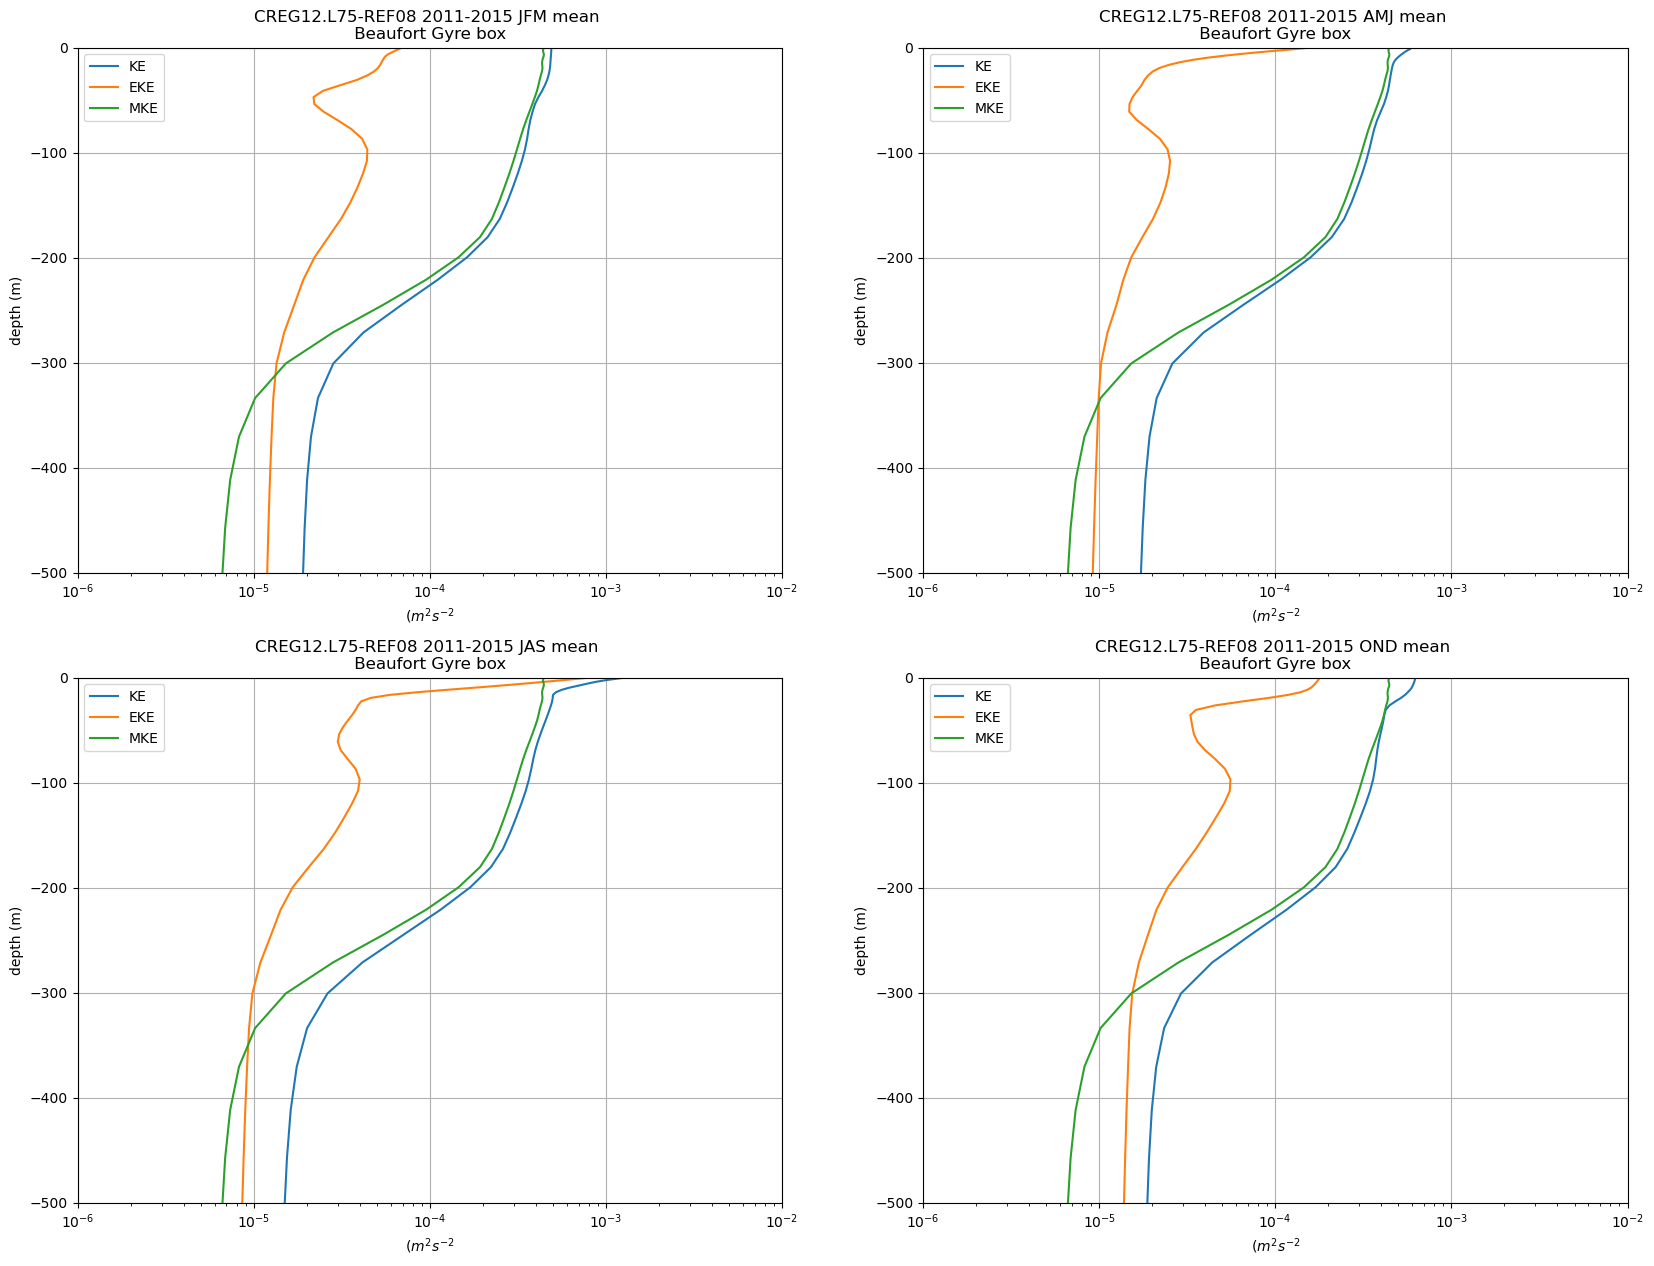

In [115]:
%%time
plt.figure(figsize=(20,15))
mydepth=500.
max_ener=10**-2
min_ener=10**-6

plt.subplot(221)
plt.plot(ds_tke_climseas.votkeZ.sel(season='JFM'),-1.*ds_tke_climseas.nav_lev,label='KE')
plt.plot(ds_eke_climseas.voekeZ.sel(season='JFM'),-1.*ds_eke_climseas.nav_lev,label='EKE')
plt.plot(ds_mke.vomkeZ,-1.*ds_mke.nav_lev,label='MKE')

plt.title('')
plt.xscale('log')
plt.title('CREG12.L75-REF08 2011-2015 JFM mean \n Beaufort Gyre box ')
plt.xlabel('($m^2s^{-2}$')
plt.ylabel('depth (m)')
plt.ylim([-1.*mydepth,0.])
plt.xlim([min_ener,max_ener])
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(222)
plt.plot(ds_tke_climseas.votkeZ.sel(season='AMJ'),-1.*ds_tke_climseas.nav_lev,label='KE')
plt.plot(ds_eke_climseas.voekeZ.sel(season='AMJ'),-1.*ds_eke_climseas.nav_lev,label='EKE')
plt.plot(ds_mke.vomkeZ,-1.*ds_mke.nav_lev,label='MKE')

plt.title('')
plt.xscale('log')
plt.title('CREG12.L75-REF08 2011-2015 AMJ mean \n Beaufort Gyre box ')
plt.xlabel('($m^2s^{-2}$')
plt.ylabel('depth (m)')
plt.ylim([-1.*mydepth,0.])
plt.xlim([min_ener,max_ener])
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(223)
plt.plot(ds_tke_climseas.votkeZ.sel(season='JAS'),-1.*ds_tke_climseas.nav_lev,label='KE')
plt.plot(ds_eke_climseas.voekeZ.sel(season='JAS'),-1.*ds_eke_climseas.nav_lev,label='EKE')
plt.plot(ds_mke.vomkeZ,-1.*ds_mke.nav_lev,label='MKE')

plt.title('')
plt.xscale('log')
plt.title('CREG12.L75-REF08 2011-2015 JAS mean \n Beaufort Gyre box ')
plt.xlabel('($m^2s^{-2}$')
plt.ylabel('depth (m)')
plt.ylim([-1.*mydepth,0.])
plt.xlim([min_ener,max_ener])
plt.grid(True)
plt.legend(loc='upper left')

plt.subplot(224)
plt.plot(ds_tke_climseas.votkeZ.sel(season='OND'),-1.*ds_tke_climseas.nav_lev,label='KE')
plt.plot(ds_eke_climseas.voekeZ.sel(season='OND'),-1.*ds_eke_climseas.nav_lev,label='EKE')
plt.plot(ds_mke.vomkeZ,-1.*ds_mke.nav_lev,label='MKE')

plt.title('')
plt.xscale('log')
plt.title('CREG12.L75-REF08 2011-2015 OND mean \n Beaufort Gyre box ')
plt.xlabel('($m^2s^{-2}$')
plt.ylabel('depth (m)')
plt.ylim([-1.*mydepth,0.])
plt.xlim([min_ener,max_ener])
plt.grid(True)
plt.legend(loc='upper left')

if False : plt.savefig('./FIGURES/CREG12.L75-REF08_TMEKE_Seas_Zprofiles_BoxBG500m_y20112015.png',dpi=300)


CPU times: user 1.76 s, sys: 416 ms, total: 2.18 s
Wall time: 1.6 s


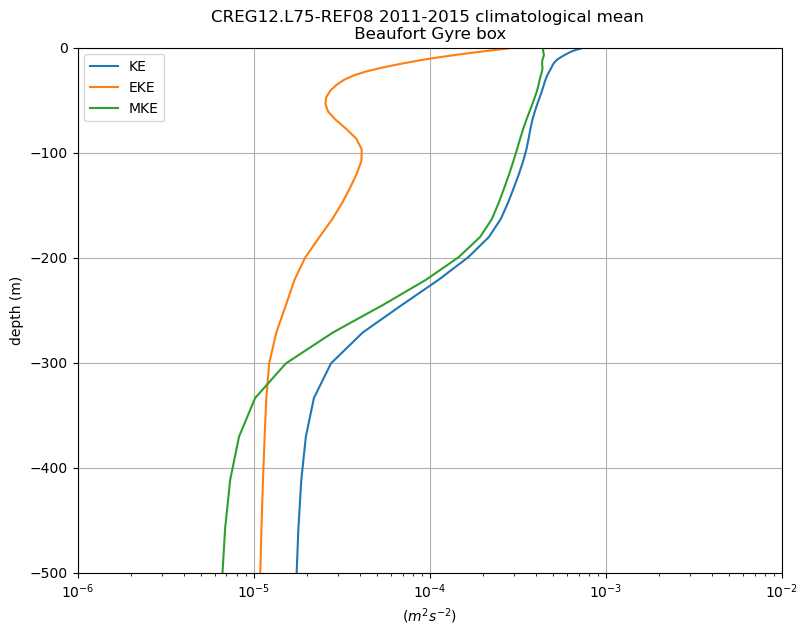

In [117]:
%%time
plt.figure(figsize=(20,15))
mydepth=500.
max_ener=10**-2
min_ener=10**-6

plt.subplot(221)
plt.plot(ds_tke_climseas.votkeZ.mean('season'),-1.*ds_tke_climseas.nav_lev,label='KE')
plt.plot(ds_eke_climseas.voekeZ.mean('season'),-1.*ds_eke_climseas.nav_lev,label='EKE')
plt.plot(ds_mke.vomkeZ,-1.*ds_mke.nav_lev,label='MKE')

plt.title('')
plt.xscale('log')
plt.title('CREG12.L75-REF08 2011-2015 climatological mean \n Beaufort Gyre box ')
plt.xlabel('($m^2s^{-2})$')
plt.ylabel('depth (m)')
plt.ylim([-1.*mydepth,0.])
plt.xlim([min_ener,max_ener])
plt.grid(True)
plt.legend(loc='upper left')

if True : plt.savefig('./FIGURES/CREG12.L75-REF08_TMEKE_Zprofiles_BoxBG500m_y20112015.png',dpi=300)


# Now compute and plot the monthly time serie in the BG box 

In [118]:
%%time 
# Loop over years 
DATAIN='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/CREG12.L75-REF08-MEAN/DIAGS/ENERGETICS/'

for cyear in np.arange(5)+2011:
 
    print('#####################################')
    print(' >>>>  The year treated is : ',cyear)
    print('#####################################')

    # Read .json files 
    print()
    print(' >>>>>>>  The current year treated is : ',cyear )
    print()
    lpath=DATAIN+str(cyear)+'/1m/'
    ds_year=xr.open_mfdataset(lpath+'CREG12.L75-REF08_y'+str(cyear)+'m*.1m_TEKE.nc',\
                            combine='nested',concat_dim=['time_counter'], \
                            chunks={'nav_lev':z_chunk,'y':y_chunk, 'x':x_chunk}, \
                            engine="netcdf4")

    # Define my own seasons 
    months=ds_year.time_counter.dt.month
    seasons=my_seasons(months) 
    #print('Months: \n', months, ' \n Seasons: \n', seasons)

    # Get clean geographical coordinates
    ds_year.coords['nav_lat']=ds_coord['nav_lat']
    ds_year.coords['nav_lon']=ds_coord['nav_lon']

    ds_year=ds_year.rename_dims({'deptht':'nav_lev'})
    ds_year=ds_year.rename_vars({'deptht':'nav_lev'})
    ds_year
    print('           Size of the yearly dataset :', ds_year.nbytes*1e-9,'GB')

    # Select a Beaufort Gyre area only and compute mean on each level
    if data_reduction_BGBox: 
        ds_BG_eke=sel_BG_box(ds_year,ds_mesh,'voeke')
        ds_BG_tke=sel_BG_box(ds_year,ds_mesh,'votke')

    # Now output the seasonal mean, monthly mean or yearly mean in this box 
    print('           Start to output the Dataset :')
    print()

    # Output seasonal mean
    fileout=str(cyear)+'/1m/'+'CREG12.L75-REF08_y'+str(cyear)+'.seas_BGBox_TEKE.nc'
    nc_seas_out(ds_BG_eke,ds_BG_tke,cyear,fileout)
            

#####################################
 >>>>  The year treated is :  2011
#####################################

 >>>>>>>  The current year treated is :  2011

           Size of the yearly dataset : 20.510941036000002 GB
           Start to output the Dataset :

#####################################
 >>>>  The year treated is :  2012
#####################################

 >>>>>>>  The current year treated is :  2012

           Size of the yearly dataset : 20.510941036000002 GB
           Start to output the Dataset :

#####################################
 >>>>  The year treated is :  2013
#####################################

 >>>>>>>  The current year treated is :  2013

           Size of the yearly dataset : 20.510941036000002 GB
           Start to output the Dataset :

#####################################
 >>>>  The year treated is :  2014
#####################################

 >>>>>>>  The current year treated is :  2014

           Size of the yearly dataset : 20.510941036

## Re-read the TKE & EKE fields computed in the BG box just above

In [185]:
if True:
    import glob
    DATAIN='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/CREG12.L75-REF08-MEAN/DIAGS/ENERGETICS/'
    lref=sorted(glob.glob(DATAIN+'*/1m/CREG12.L75-REF08_y*.seas_BGBox_TEKE.nc'))
    ds_ene_seas=xr.open_mfdataset(lref,\
                            combine='nested',concat_dim=['time_counter'], \
                            chunks={'nav_lev':z_chunk,'y':y_chunk, 'x':x_chunk}, \
                            engine="netcdf4")


In [186]:
# Set a depth axis with negative values for the plot purpose 
ds_ene_seas.coords['nav_lev']=-1.*ds_ene_seas.coords['nav_lev']

## Prepare the MKE field as well

In [201]:
if True:
    # Read original NetcDF files
    import glob
    DATAIN='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/CREG12.L75-REF08-MEAN/DIAGS/ENERGETICS/'
    lvar_ene='MKE'  ; zvar='vomke'
    lref=sorted(glob.glob(DATAIN+'/*/1y/CREG12.L75-REF08_y*.1y_'+lvar_ene+'.nc'))

    ds_year=xr.open_mfdataset(lref,chunks={'time_counter':1 ,'deptht':15,'y':500, 'x':500},combine='nested',concat_dim=['time_counter'],engine="netcdf4")
    ds_year=ds_year.rename_dims({'deptht':'nav_lev'})
    ds_year=ds_year.rename_vars({'deptht':'nav_lev'})
    ds_year=ds_year.set_coords('nav_lat')
    ds_year=ds_year.set_coords('nav_lon')

# Remove a spurious time_counter variable & rebuild geographical cord. without a time axis
xlon=ds_year['nav_lon'].isel(time_counter=0)  ; xlat=ds_year['nav_lat'].isel(time_counter=0)
ds_year=ds_year.drop_vars('time_counter')
ds_year=ds_year.drop_vars('nav_lat') 
ds_year=ds_year.drop_vars('nav_lon')
ds_year.coords['nav_lon']=xlon.drop_vars('time_counter')
ds_year.coords['nav_lat']=xlat.drop_vars('time_counter')

# Reduce to the BG box area
if data_reduction_BGBox: 
        ds_mke_BG=sel_BG_box(ds_year,ds_mesh,'vomke')

# Duplicate the yearly MKE for each month
data=[]
# Append the slices
for year in np.arange(5):
    for iter in np.arange(12): 
        data.append(ds_mke_BG.vomkeZ.isel(time_counter=year))
        
ds_mke_month= xr.concat(data, dim='time_counter')
ds_mke_month['time_counter']=ds_ene_seas['time_counter']

<timed exec>:19: UserWarning: Log scale: values of z <= 0 have been masked


CPU times: user 4.34 s, sys: 1.37 s, total: 5.71 s
Wall time: 4.6 s


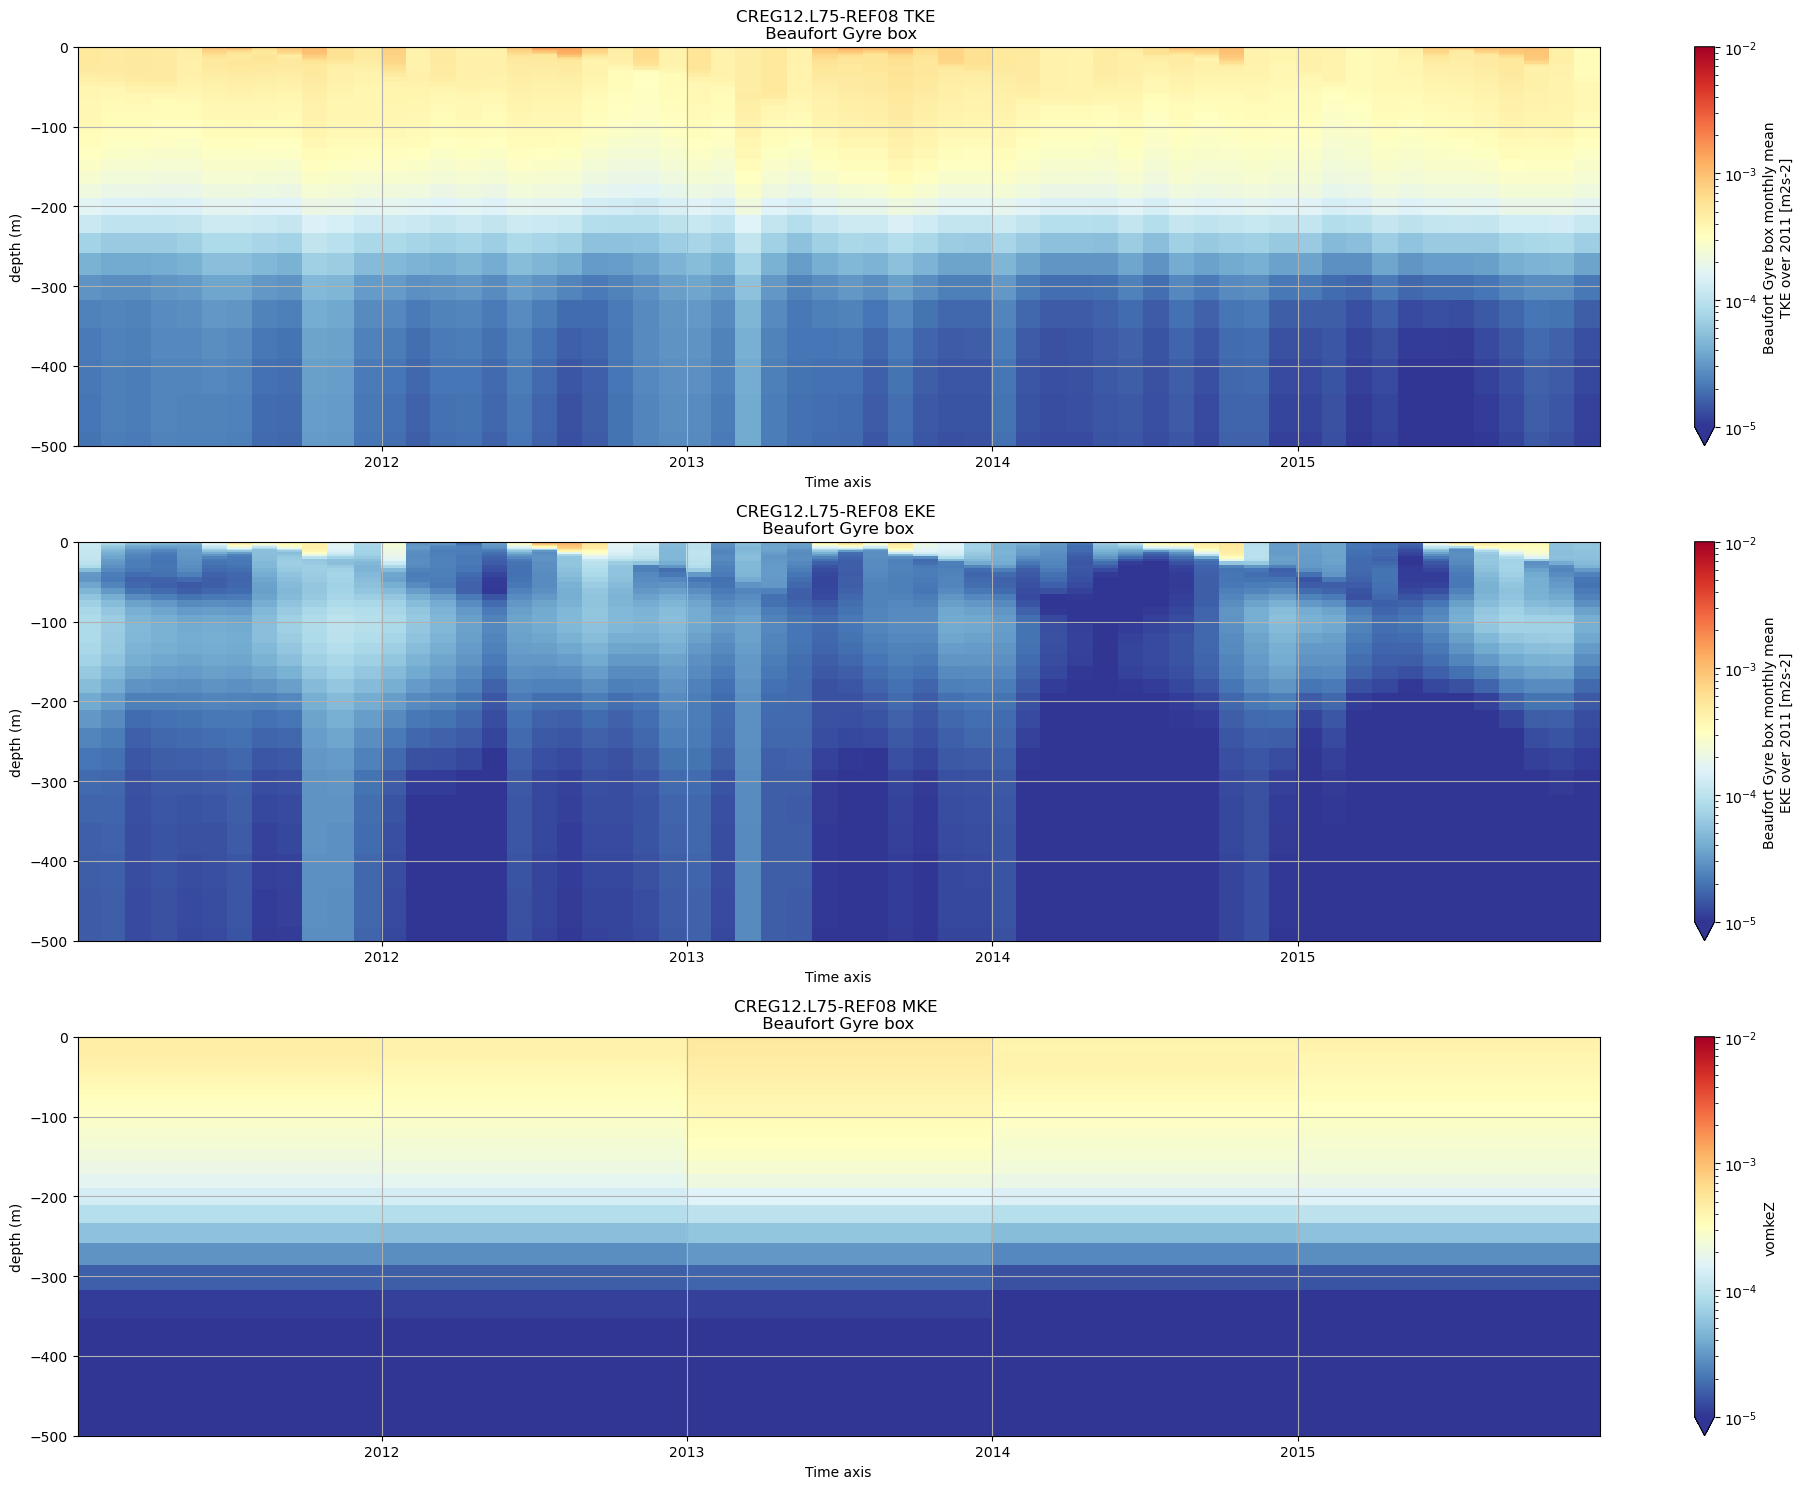

In [207]:
%%time
plt.figure(figsize=(20,15))
mydepth=-500.

logvmin=10**-5 ; logvmax=10**-2 
znorm=mpl.colors.LogNorm(vmin=logvmin,vmax=logvmax)

plt.subplot(311)
(ds_ene_seas.votkeZ_month).plot(y='nav_lev', x='time_counter',label='KE',cmap='RdYlBu_r',norm=znorm,\
                                 add_colorbar=True, cbar_kwargs={'location': 'right'})

plt.title('CREG12.L75-REF08 TKE \n Beaufort Gyre box')
plt.ylabel('depth (m)')
plt.ylim([mydepth,0.])
plt.grid(True)
#plt.legend()

plt.subplot(312)
(ds_ene_seas.voekeZ_month).plot(y='nav_lev', x='time_counter',label='KE',cmap='RdYlBu_r',norm=znorm)
plt.contour(ds_ene_seas.voekeZ_month,levels=[10**-4,10**-3],colors='w',norm=znorm)

plt.title('CREG12.L75-REF08 EKE \n Beaufort Gyre box ')
plt.ylabel('depth (m)')
plt.ylim([mydepth,0.])
plt.grid(True)
#plt.legend()

plt.subplot(313)
(ds_mke_month).plot(y='nav_lev', x='time_counter',label='MKE',cmap='RdYlBu_r',norm=znorm)

plt.title('CREG12.L75-REF08 MKE \n Beaufort Gyre box ')
plt.ylabel('depth (m)')
plt.ylim([mydepth,0.])
plt.grid(True)
#plt.legend()

plt.tight_layout()

if True : plt.savefig('./FIGURES/CREG12.L75-REF08_TMEKE_monthly_ZTime_BoxBG500m_y20112015.png',dpi=300)


# Find the best box in the Beaufort gyre 

In [17]:
x_chunk=500  ;  y_chunk=500  ;   z_chunk=1

In [18]:
DATAIN='/home/datawork-lops-drakkarcom/SIMULATION-OUTPUTS/FREDY/CONFIGS/CREG12.L75/CREG12.L75-REF08-MEAN/DIAGS/ENERGETICS/'
cyear=2011
lpath=DATAIN+str(cyear)+'/1y/'
ds_meanyear=xr.open_dataset(lpath+'CREG12.L75-REF08_y'+str(cyear)+'.1y_MKE.nc',\
                        chunks={'nav_lev':z_chunk,'y':y_chunk, 'x':x_chunk}, \
                        engine="netcdf4")

In [19]:
ds_meanyear=ds_meanyear.set_coords('nav_lon')
ds_meanyear=ds_meanyear.set_coords('nav_lat')

In [25]:
ds_meanyear=ds_meanyear.rename_vars({'deptht':'nav_lev'})
ds_meanyear=ds_meanyear.rename_dims({'deptht':'nav_lev'})

In [26]:
ds_meanyear

<xarray.Dataset>
Dimensions:       (y: 1801, x: 1580, nav_lev: 75, time_counter: 1)
Coordinates:
    nav_lon       (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
    nav_lat       (y, x) float32 dask.array<chunksize=(500, 500), meta=np.ndarray>
  * nav_lev       (nav_lev) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time_counter  (time_counter) object 2011-07-02 11:58:56
Dimensions without coordinates: y, x
Data variables:
    vomke         (time_counter, nav_lev, y, x) float32 dask.array<chunksize=(1, 75, 500, 500), meta=np.ndarray>
    ds_BG_area    (y, x) bool False False False False ... False False False
Attributes:
    start_date:        19790101
    output_frequency:  5d
    CONFIG:            CREG12.L75
    CASE:              REF08

In [57]:

%%time
ds_meanyear['ds_BG_area']=((ds_meanyear.coords['nav_lat']<=79.) & (ds_meanyear.coords['nav_lat']>=73.) & \
                           (ds_meanyear.coords['nav_lon']>=-153.) & (ds_meanyear.coords['nav_lon']<=-137.)).compute()

CPU times: user 84 ms, sys: 36 ms, total: 120 ms
Wall time: 424 ms


In [58]:
box_BG=xr.where(ds_meanyear['ds_BG_area'],1.,np.nan)

/dev/shm/pbs.8760625.datarmor0/ipykernel_5925/2169728710.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  pal = plt.cm.get_cmap('binary')
/dev/shm/pbs.8760625.datarmor0/ipykernel_5925/1438417843.py:35: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  m.pcolormesh(X,Y,ztab,cmap=zmap,norm=znorm)
<timed exec>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


CPU times: user 6.88 s, sys: 392 ms, total: 7.27 s
Wall time: 7.12 s


<Figure size 640x480 with 0 Axes>

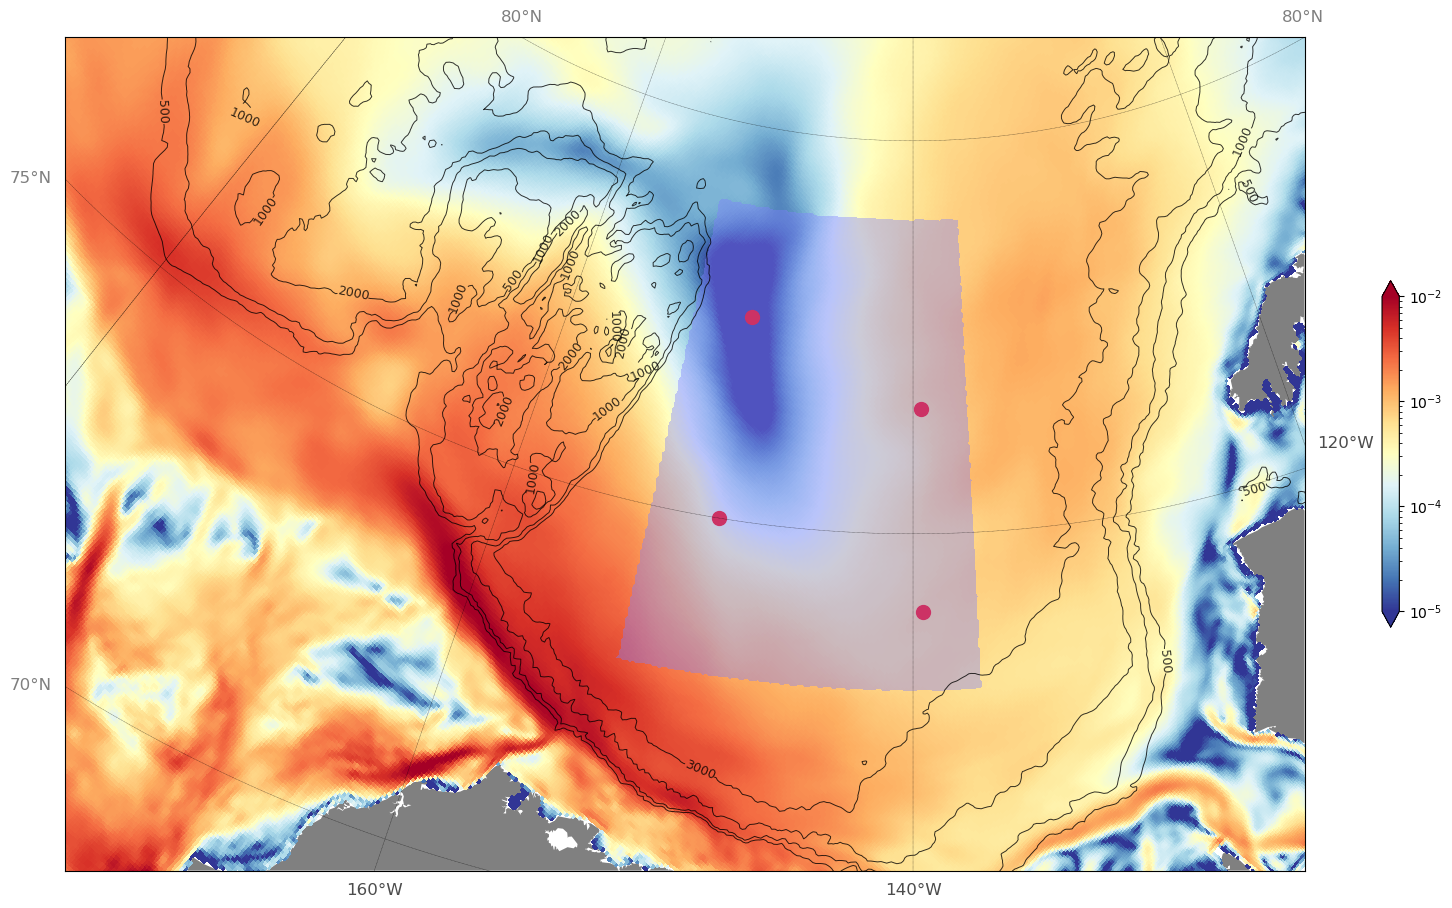

In [59]:
%%time

plt.clf()
vmin=10**-5. ; vmax=10**-2. ; vint=0.1
contours=np.arange(vmin,vmax+vint,vint)
limits=[vmin,vmax]   
    
fig=plt.figure(figsize=(20,15))
plt.subplot(111)
C1=Arc_plot(np.array(ds_meanyear['nav_lon']),np.array(ds_meanyear['nav_lat']), \
          (ds_meanyear['vomke']).sel(nav_lev=0.,method='nearest').isel(time_counter=0), \
         contours, limits, zmap='RdYlBu_r',proj='cassis_BGZoom',fld='EKE',log10=True,pltbat=ds_sedna_bat)

norm = mpl.colors.Normalize(vmin=0., vmax=1.)
pal = plt.cm.get_cmap('cool')

# Plot the moorings location from the BGEP obs.
moorA={'lon':-149.57,'lat':75.}
moorB={'lon':-149.59,'lat':77.59}
moorC={'lon':-139.57,'lat':76.59}
moorD={'lon':-139.54,'lat':74.0}
MOOR=[moorA,moorB,moorC,moorD]

for moor in MOOR:
    x,y = C1(moor['lon'],moor['lat'])
    C1.scatter(x,y,100,marker='o', color='r')

X,Y = C1(np.array(ds_meanyear['nav_lon']),np.array(ds_meanyear['nav_lat']))
C2= C1.contourf(X,Y,box_BG,[0.,1.],cmap=pal,norm=norm,alpha=0.4)


In [209]:
client.close()
cluster.close()

/home1/datawork/ctalandi/conda-env/Jupyter-Dask/lib/python3.11/site-packages/dask_jobqueue/core.py:255: FutureWarning: job_extra has been renamed to job_extra_directives. You are still using it (even if only set to []; please also check config files). If you did not set job_extra_directives yet, job_extra will be respected for now, but it will be removed in a future release. If you already set job_extra_directives, job_extra is ignored and you can remove it.
  warnings.warn(warn, FutureWarning)
